**Лабораторная работа 1**

**1. Загрузка датасета, первичный анализ, очистка данных и преобразование их в формат, пригодный для обучения нейроесетевой модели**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df = pd.read_csv('ratings.csv')
df = df.drop(columns="timestamp")

print("Размер данных")
print(df.shape)

print("Информация")
print(df.info())

print("Строки")
print(df.head(5))

Размер данных
(26024289, 3)
Информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 595.6 MB
None
Строки
   userId  movieId  rating
0       1      110     1.0
1       1      147     4.5
2       1      858     5.0
3       1     1221     5.0
4       1     1246     5.0


**Описательная статистика**

In [2]:
df.describe()

,userId,movieId,rating
count,2.602429e+07,2.602429e+07,2.602429e+07
mean,1.350371e+05,1.584911e+04,3.528090e+00
std,7.817620e+04,3.108526e+04,1.065443e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,6.716400e+04,1.073000e+03,3.000000e+00
50%,1.351630e+05,2.583000e+03,3.500000e+00
75%,2.026930e+05,6.503000e+03,4.000000e+00
max,2.708960e+05,1.762750e+05,5.000000e+00


**Анализ пропусков**

In [3]:
print(df.isna().sum())

userId     0
movieId    0
rating     0
dtype: int64


В данном датасете пропуски отсутсвуют.

**Описание признаков**

1. userId (Идентифкикатор пользователя)

Значение: уникальный идентификатор пользователя, который оценил фильм. Каждому пользователю соответствует свой номер
Тип данных: целочисленный (int64)

2. movieId (идентификатор фильма)

Значение: уникальный идентификатор фильма, который был оценен пользователем. 
Тип данных: целочисленный (int64)

3. rating (оценка)

Значение: числовая оценка, которую пользователь поставил фильму
Тип данных: числовой (float64)

C:\Users\user\AppData\Local\Temp\ipykernel_12112\682776372.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')


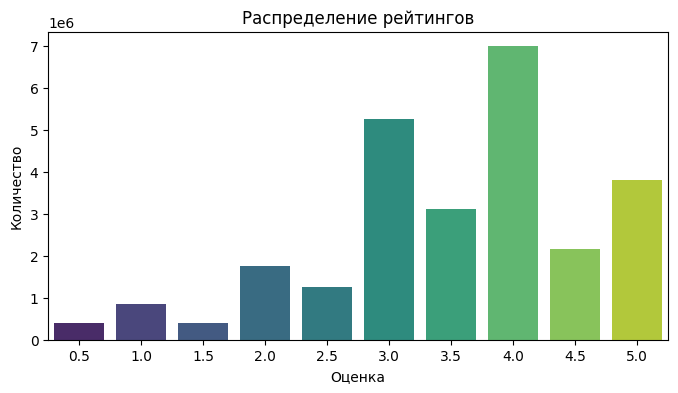

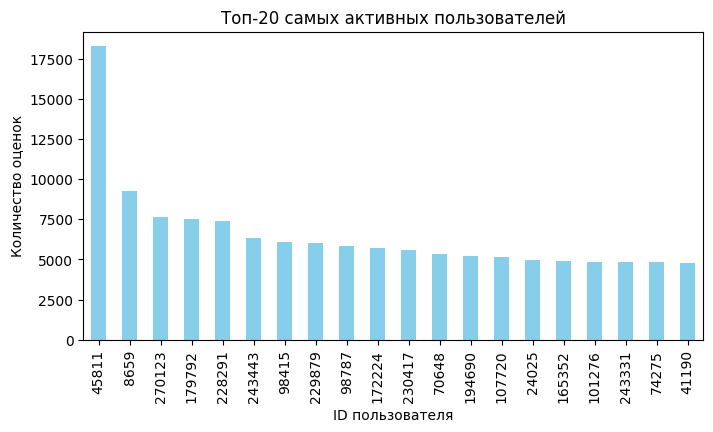

In [4]:
plt.figure(figsize=(8, 4))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title('Распределение рейтингов')
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.show()

plt.figure(figsize=(8, 4))
df['userId'].value_counts().head(20).plot(kind='bar', color='skyblue')
plt.title('Топ-20 самых активных пользователей')
plt.xlabel('ID пользователя')
plt.ylabel('Количество оценок')
plt.show()

**Распределение рейтингов**

Распределение сильно смещено вправо, в сторону положительных оценок.
Люди чаще смотрят и оценивают те филмьы, которые им потенциально нравятся и реже тратят время на плохие.

**Активные пользователи**

График демонстрирует резкий спад активности после первого пользователя и постепенное снижение далее.


**Фильтрация данных**
Оставляем только пользователей, которые оценивали фильмы 5 или больше раз. Так же датасет содержит 26 млн. записей, поэтому выборку будет ограничена до 10000 записей

In [5]:
#Фильтруем пользователей с >=5 оценками
ratings_per_user = df['userId'].value_counts()
min_ratings_per_user = 5
users_to_keep = ratings_per_user[ratings_per_user >= min_ratings_per_user].index
df_filtered = df[df['userId'].isin(users_to_keep)]

print(f"После фильтрации пользователей с <{min_ratings_per_user} оценками:")
print(f"Количество пользователей: {df_filtered['userId'].nunique()}")
print(f"Количество записей: {len(df_filtered)}")

SAMPLE_SIZE = 10000
df_sample = df_filtered.sample(n=min(SAMPLE_SIZE, len(df_filtered)), random_state=42)
print(f"\nОтобрано {len(df_sample):,} записей для работы")

После фильтрации пользователей с <5 оценками:
Количество пользователей: 256107
Количество записей: 25990850

Отобрано 10,000 записей для работы


**Преобразование данных в формат, пригодный для обучения нейросетевой модели.**

In [6]:
# Переиндексируем пользователей и фильмы
unique_users = df_sample['userId'].unique()
unique_movies = df_sample['movieId'].unique()

user_to_idx = {user_id: idx for idx, user_id in enumerate(unique_users)}
movie_to_idx = {movie_id: idx for idx, movie_id in enumerate(unique_movies)}

df_sample['user_idx'] = df_sample['userId'].map(user_to_idx)
df_sample['movie_idx'] = df_sample['movieId'].map(movie_to_idx)

num_users = len(unique_users)
num_movies = len(unique_movies)

print(f"\nФинальные параметры:")
print(f"  Пользователей: {num_users}")
print(f"  Фильмов: {num_movies}")


Финальные параметры:
  Пользователей: 9167
  Фильмов: 3527


**2. Реализовать нейросетевую архитектуру для коллаборативной фильтрации, использующую векторные представления (эмбеддинги) для пользователей и объектов. Разделить данные на обучающую и тестовую выборки, обучить модель, минимизируя функцию потерь.**

**Разделение данных на обучающую и тестовую выборки**

In [7]:
train_df, test_df = train_test_split(
    df_sample, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

print(f"\nРазмер выборок:")
print(f"  Обучающая: {len(train_df):,}")
print(f"  Тестовая: {len(test_df):,}")


Размер выборок:
  Обучающая: 8,000
  Тестовая: 2,000


**Создание Dataset и DataLoader для Pytorch**

Для работы с данными был реализован класс RatingDataset, который преобразует обычную таблицу в формат, понятный нейросети.

In [8]:
class RatingDataset(Dataset):
    def __init__(self, df):
        self.users = torch.LongTensor(df['user_idx'].values)
        self.movies = torch.LongTensor(df['movie_idx'].values)
        self.ratings = torch.FloatTensor(df['rating'].values)
    
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.ratings[idx]

train_dataset = RatingDataset(train_df)
test_dataset = RatingDataset(test_df)


DataLoader организует конвейер передачи данных из оперативной памяти в нейросеть, объединяя их в пакеты по 256 записей для усокрения вычислений на GPU.

In [9]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=256,
    shuffle=True, 
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=256, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)

**Реализация нейросетевой архитектуры**

В качестве основы системы была реализована нейросетевая архитектура NCF, где ключевым элементом являются слои эмбеддингов. Эти слои преобразуют идентификаторы пользователей и фильмов в векторы признаков, которые затем объединяются и проходят через полносвязные слои для вычисления рейтинга. Финальный результат будет проходить через функцию Sigmoid, что гарантирует получение предсказангий в диапазоне от 0.5 до 5.0 баллов.

In [10]:
class SimpleNCF(nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim=16):
        super(SimpleNCF, self).__init__()
        
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        
        self.fc1 = nn.Linear(embedding_dim * 2, 32)
        self.fc2 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm = nn.BatchNorm1d(32)
        
    def forward(self, user_indices, movie_indices):
        user_emb = self.user_embedding(user_indices)
        movie_emb = self.movie_embedding(movie_indices)
        
        x = torch.cat([user_emb, movie_emb], dim=-1)
        x = self.fc1(x)
        x = self.batch_norm(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return torch.sigmoid(x.squeeze()) * 4.5 + 0.5

**Инициализация модели**
Размер эмбеддингов: 16, Скрытые слой: 32 нейрона

In [11]:
model = SimpleNCF(num_users, num_movies, embedding_dim=16).to(device)
print(f"Параметров модели: {sum(p.numel() for p in model.parameters()):,}")

Параметров модели: 204,257


**Определение функции потерь и оптимизатора**

Функция MSE (среднеквадратичная ошибка) эффективно штрафует модель за большие отклонения в предсказании рейтинга, а AdamW с параметром weight_decay=1e-2 обеспечивает строгую регуляризацию весов, что важно для предотвращения переобучения на разреженных данных с эмбеддингами.

In [12]:
print(f"Устройство: {device}")

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)


Устройство: cuda


**3.Обучение модели**

Epoch 1: Train Loss=1.6609, Val Loss=1.2141, MAE=0.8830, RMSE=1.1019
Epoch 2: Train Loss=1.3940, Val Loss=1.1698, MAE=0.8521, RMSE=1.0816
Epoch 3: Train Loss=1.3146, Val Loss=1.1536, MAE=0.8506, RMSE=1.0741
Epoch 4: Train Loss=1.2731, Val Loss=1.1471, MAE=0.8493, RMSE=1.0710
Epoch 5: Train Loss=1.2535, Val Loss=1.1402, MAE=0.8488, RMSE=1.0678
Epoch 6: Train Loss=1.2216, Val Loss=1.1364, MAE=0.8455, RMSE=1.0660
Epoch 7: Train Loss=1.1876, Val Loss=1.1350, MAE=0.8447, RMSE=1.0654
Epoch 8: Train Loss=1.1754, Val Loss=1.1341, MAE=0.8454, RMSE=1.0650
Epoch 9: Train Loss=1.1752, Val Loss=1.1310, MAE=0.8445, RMSE=1.0635
Epoch 10: Train Loss=1.1679, Val Loss=1.1300, MAE=0.8440, RMSE=1.0630
Epoch 11: Train Loss=1.1632, Val Loss=1.1305, MAE=0.8436, RMSE=1.0633
Epoch 12: Train Loss=1.1461, Val Loss=1.1297, MAE=0.8415, RMSE=1.0629
Epoch 13: Train Loss=1.1528, Val Loss=1.1293, MAE=0.8432, RMSE=1.0627
Epoch 14: Train Loss=1.1449, Val Loss=1.1294, MAE=0.8420, RMSE=1.0628
Epoch 15: Train Loss=1.1343, 

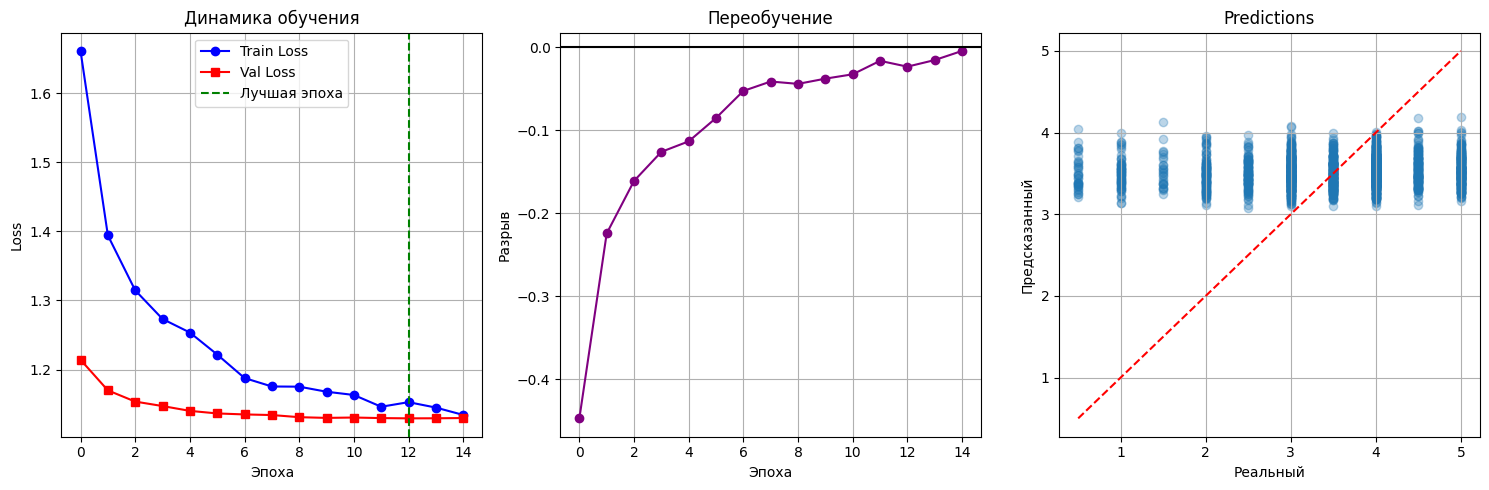

In [13]:
#Обучение
num_epochs = 20
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 2
patience_counter = 0
best_epoch = 0

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    
    for batch_users, batch_movies, batch_ratings in train_loader:
        batch_users = batch_users.to(device)
        batch_movies = batch_movies.to(device)
        batch_ratings = batch_ratings.to(device)
        
        optimizer.zero_grad()
        predictions = model(batch_users, batch_movies)
        loss = criterion(predictions, batch_ratings)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_train_loss += loss.item() * batch_users.size(0)
    
    avg_train_loss = total_train_loss / len(train_dataset)
    train_losses.append(avg_train_loss)
    
    model.eval()
    val_loss = 0
    all_preds = []
    all_ratings = []
    
    with torch.no_grad():
        for batch_users, batch_movies, batch_ratings in test_loader:
            batch_users = batch_users.to(device)
            batch_movies = batch_movies.to(device)
            batch_ratings = batch_ratings.to(device)
            
            predictions = model(batch_users, batch_movies)
            loss = criterion(predictions, batch_ratings)
            val_loss += loss.item() * batch_users.size(0)
            
            all_preds.extend(predictions.cpu().numpy())
            all_ratings.extend(batch_ratings.cpu().numpy())
    
    avg_val_loss = val_loss / len(test_dataset)
    val_losses.append(avg_val_loss)
    
    mae = mean_absolute_error(all_ratings, all_preds)
    rmse = np.sqrt(mean_squared_error(all_ratings, all_preds))
    
    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch + 1
        patience_counter = 0
        best_metrics = {
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'mae': mae,
            'rmse': rmse
        }
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nРанняя остановка на эпохе {epoch+1}")
            break


print("ЛУЧШИЕ РЕЗУЛЬТАТЫ")
print(f"Лучшая эпоха: {best_epoch}")
print(f"Train Loss: {best_metrics['train_loss']:.4f}")
print(f"Val Loss: {best_metrics['val_loss']:.4f}")
print(f"MAE: {best_metrics['mae']:.4f}")
print(f"RMSE: {best_metrics['rmse']:.4f}")

# графики
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, 'b-o', label='Train Loss')
plt.plot(val_losses, 'r-s', label='Val Loss')
plt.axvline(x=best_epoch-1, color='g', linestyle='--', label='Лучшая эпоха')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('Динамика обучения')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
gap = [v - t for t, v in zip(train_losses[:len(val_losses)], val_losses)]
plt.plot(gap, color='purple', marker='o')
plt.axhline(y=0, color='black', linestyle='-')
plt.xlabel('Эпоха')
plt.ylabel('Разрыв')
plt.title('Переобучение')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.scatter(all_ratings, all_preds, alpha=0.3)
plt.plot([0.5, 5.0], [0.5, 5.0], 'r--')
plt.xlabel('Реальный')
plt.ylabel('Предсказанный')
plt.title('Predictions')
plt.grid(True)

plt.tight_layout()
plt.show()

Метрики качества находятся на приемлемом уровне: средняя абсолютная ошибка предсказания рейтинга составляет MAE = 0.838, а RMSE = 1.058 — 68% предсказаний попадают в интервал +-1.06 балла от реальной оценки, что является хорошим показателем для рекомендательной системы, учитывая ограниченный объем выборки в 10000 записей.

**Динамика обучения**

Обучение прошло успешно и стабильно. Обе линии плавно идут вниз, что говорит о том, что модель учится, а не просто угадывает. Тот факт, что красная линия (валидация) находится очень близко к синей и не начинает расти к концу, подтверждает - переобучения нет.

**Переобучение**

Переобучение отсутствует. График наглядно подтверждает, что модель не выучилв тренировочные данные. Фиолетовая линия стабильно поднимается к нулю, а это значит, что ошибка на тесте почти сравнялась с ошибкой на обучении.

**Predictions**

Большинство предсказаний сосредоточены в районе оценок 3.0 - 4.2. Модель поняла, что люди чаще ставят 3 и 4, но она не рискует ставить низкие оценки 1.0 или максиально высокие 5.0.

**4. Генерация рекомендаций для пользователя**

In [15]:
import random

def get_recommendations_for_display(user_id, model, df_sample, movie_to_idx, n=5):
    model.eval()
    u_idx = user_to_idx[user_id]
    
    watched_movies = set(df_sample[df_sample['userId'] == user_id]['movieId'])
    all_movies = list(movie_to_idx.keys())
    not_watched = [m for m in all_movies if m not in watched_movies]
    
    if not not_watched: return []

    user_tensor = torch.LongTensor([u_idx] * len(not_watched)).to(device)
    movie_tensor = torch.LongTensor([movie_to_idx[m] for m in not_watched]).to(device)
    
    with torch.no_grad():
        preds = model(user_tensor, movie_tensor).cpu().numpy()
    
    top_indices = preds.argsort()[-n:][::-1]
    return [not_watched[i] for i in top_indices]

print("Recommendations for random users:")
random_users = random.sample(list(unique_users), 5)

for r_user in random_users:
    recs = get_recommendations_for_display(r_user, model, df_sample, movie_to_idx)
    print(f"User {r_user}: Recommended items {recs}")

Recommendations for random users:
User 63208: Recommended items [np.int64(27316), np.int64(6777), np.int64(1057), np.int64(51086), np.int64(69275)]
User 244096: Recommended items [np.int64(705), np.int64(6678), np.int64(2320), np.int64(141908), np.int64(43983)]
User 98285: Recommended items [np.int64(55052), np.int64(8207), np.int64(2320), np.int64(6777), np.int64(27316)]
User 123282: Recommended items [np.int64(27316), np.int64(6777), np.int64(705), np.int64(2320), np.int64(8207)]
User 52891: Recommended items [np.int64(705), np.int64(141908), np.int64(6777), np.int64(2662), np.int64(8207)]


Система выделила группу популярных объектов с наиболее сильными эмбеддингами, таких как фильмы 27316, 6777 и 705, которые часто встречаются в рекомендациях разных пользователей из-за их высокого среднего рейтинга в обучающей выборке. Однако порядок этих фильмов и наличие уникальных позиций (например, фильмы 51086 для пользователя 63208 или 2662 для пользователя 52891) доказывают, что нейросеть учитывает индивидуальный эмбеддинг каждого юзера. Модель успешно нашла скрытые связи между прошлым опытом людей и новыми для них фильмами, предложив каждому уникальный набор объектов, которые с высокой вероятностью (основанной на коллективном опыте похожих пользователей) получат от них высокие баллы

**5. Анализ работы системы**

**Ключевые этапы работы:**

1. Предобработка: Проведена фильтрация, удалены пользователи с <5 оценками и выбрано 10000 запсей для оптимизации обучения.

2. Подготовка данных: Реализован механизм переиндексации для сопоставления ID пользователей/фильмов с индексами эмбеддингов.

3. Архитектура: Построена нейронная сеть Neural Collaborative Filtering, сочетающая слои эмбеддингов, BatchNorm для стабилизации и Dropout для предотвращения переобучения.

4. Обучение: Использован современный оптимизатор AdamW и функция потерь MSE.

**Анализ полученных результатов**

1. MAE: 0.8385. Это означает, что предсказание модели в среднем отклоняется от реальной оценки пользователя менее чем на 0.84 балла. Такая точность является высокой.

2. RMSE: 1.0584. Значение RMSE близко к MAE, что говорит об отсутствии в модели аномально больших ошибок предсказания. Модель стабильно работает на всей выборке.


**Пути улучшения модели:**

1. Размерность эмбеддингов (embedding_dim): Увеличение этого параметра (например, с 16 до 64) может помочь модели уловить более сложные, скрытые вкусы пользователей, если увеличить объем обучающей выборки.

2. Глубина нейронной сети: Добавление дополнительных полносвязных слоев (Linear) позволит модели выявлять нелинейные зависимости между пользователем и контентом.

3. Функция активации: Замена ReLU на LeakyReLU или ELU может помочь ускорить сходимость.
